# Prediction of origin for single electron event
This notebook aims to build a model able to predict where a single electron event originated.

In [1]:
"""
Here are the data files.  For all data files each image and label is on one row.  
The first 256 values in each row correspond to the 16x16 detector image and 
the last 6 values correspond to Energy1, Xpos1, Ypos1, Energy2, Xpos2, Ypos2.  
If there is no second particle then Energy2 = 0 and Xpos2 and Ypos2 are both -100.  
(When I run my model, I have to reset the -100 to 0).
 
CeBr10kSingle are 10,000 rows of data and labels for single interactions in the detector
CeBr10k_1.txt is 10,000 rows of data and labels with a mix of single interactions and double interactions
CeBr10.txt is a small file I use which contains 10 single interactions.
"""

import numpy as np
import matplotlib.pyplot as plt
from data_functions import separate_simulated_data

# File import
PATH = "../data/small_sample/"
filenames = ["CeBr10kSingle_1.txt", "CeBr10kSingle_2.txt", "CeBr10k_1.txt", "CeBr10.txt"]

## single, mix, small define which dataset to load.
file_to_load = "combined_single"

if file_to_load == "single_1":
    infile = PATH+filenames[0]
if file_to_load == "single_2":
    infile = PATH+filenames[1]
if file_to_load == "mix":
    infile = PATH+filenames[2]
if file_to_load == "small":
    infile = PATH+filenames[3]
if file_to_load == "combined_single":
    infile = PATH+filenames[0]
    infile2 = PATH+filenames[1]

data = np.loadtxt(infile)

if file_to_load == "combined_single":
    data2 = np.loadtxt(infile2)
    data = np.concatenate((data, data2))
    
images, energies, positions = separate_simulated_data(data)
single_positions = positions[:,:2]


print("Image data shape: {}".format(images.shape))
print("Energies shape: {}".format(energies.shape))
print("Positions shape: {}".format(positions.shape))
print("Single positions shape: {}".format(single_positions.shape))
      

Image data shape: (20000, 16, 16, 1)
Energies shape: (20000, 2)
Positions shape: (20000, 4)
Single positions shape: (20000, 2)



## Set up training and test data

In [2]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(images, single_positions, test_size = 0.2)
print("Training and test data shapes:")
print("x_train: {}".format(x_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_train: {}".format(y_train.shape))
print("y_test: {}".format(y_test.shape))




Training and test data shapes:
x_train: (16000, 16, 16, 1)
x_test: (4000, 16, 16, 1)
y_train: (16000, 2)
y_test: (4000, 2)


## Build and compile model
Using Keras as our framework with Tensorflow backend

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend

# Set up sequetial model based on Keras CIFAR-10 example
model = Sequential()

# Add layers
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
#model.add(Conv2D(32, (3, 3)))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

#model.add(Conv2D(64, (3, 3), padding='same'))
#model.add(Activation('relu'))
#model.add(Conv2D(64, (3, 3)))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
#model.add(Dense(16))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('linear'))



# Custom definition of R2 score for metrics
def r2_keras(y_true, y_pred):
    SS_res =  backend.sum(backend.square(y_true - y_pred)) 
    SS_tot = backend.sum(backend.square(y_true - backend.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + backend.epsilon()) )

# Compile model
model.compile(loss='mse',
              optimizer='adam',
              metrics=[r2_keras])

# Output summary
print(model.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 16, 16, 32)        320       
_________________________________________________________________
activation_5 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 16386     
_________________________________________________________________
activation_6 (Activation)    (None, 2)                 0         
Total params: 16,706
Trainable params: 16,706
Non-trainable params: 0
_________________________________________________________________
None


## Train the model
We also output the mean squared error and R2-score as evaluation metrics

In [4]:
# Parameters for the model
batch_size = 32
epochs = 25

model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

W0803 11:51:21.178301 140620880344704 deprecation_wrapper.py:119] From /home/ulvik/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0803 11:51:21.272087 140620880344704 deprecation_wrapper.py:119] From /home/ulvik/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 16000 samples, validate on 4000 samples
Epoch 1/25
16000/16000 [==============================] - 3s 184us/step - loss: 164.1928 - r2_keras: -8.5444 - val_loss: 16.9850 - val_r2_keras: 0.0477
Epoch 2/25
16000/16000 [==============================] - 3s 159us/step - loss: 9.4959 - r2_keras: 0.4577 - val_loss: 7.0274 - val_r2_keras: 0.6047
Epoch 3/25
16000/16000 [==============================] - 3s 177us/step - loss: 4.8699 - r2_keras: 0.7213 - val_loss: 3.9328 - val_r2_keras: 0.7777
Epoch 4/25
16000/16000 [==============================] - 3s 183us/step - loss: 3.0800 - r2_keras: 0.8238 - val_loss: 2.5386 - val_r2_keras: 0.8565
Epoch 5/25
16000/16000 [==============================] - 2s 155us/step - loss: 2.1889 - r2_keras: 0.8749 - val_loss: 1.9184 - val_r2_keras: 0.8913
Epoch 6/25
16000/16000 [==============================] - 2s 156us/step - loss: 1.6457 - r2_keras: 0.9054 - val_loss: 1.4275 - val_r2_keras: 0.9196
Epoch 7/25
16000/16000 [==============================] - 3

## Predict on test-set and plot some examples
To compare predicted positions with actual positions. 

In [5]:
predicted_pos = model.predict(x_test)

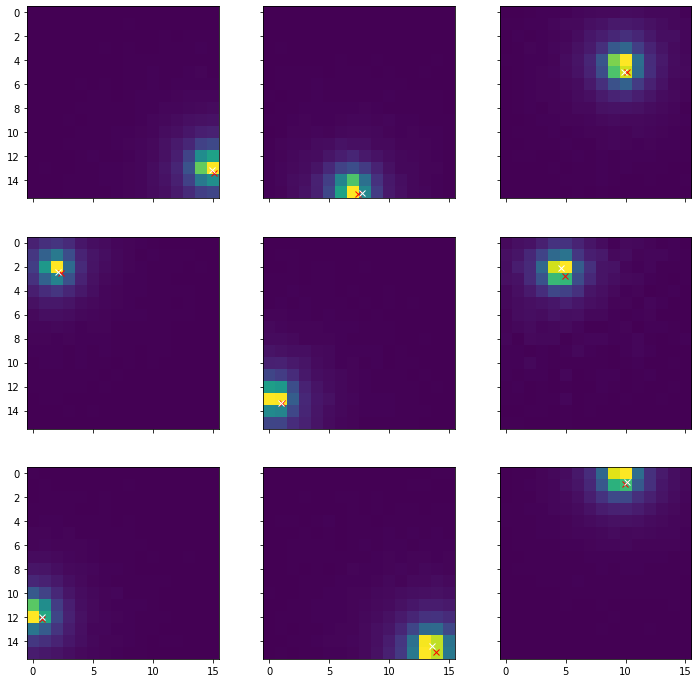

In [6]:


# Plot some images, with electron origin positions
%matplotlib inline

index = 100
fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12,12))

# Reshape test-data for plotting
x_plot = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2])
for i in range(3):
    for j in range(3):
        # plot image
        ax[i, j].imshow(x_plot[index + i*3 + j])
        
        # plot true origin of event
        x = y_test[index + i*3 + j][0]
        y = y_test[index + i*3 + j][1]
        ax[i, j].plot(x, y, 'rx')
        
        # plot predicted origin of event
        x_pred = predicted_pos[index + i*3 + j][0]
        y_pred = predicted_pos[index + i*3 + j][1]
        ax[i, j].plot(x_pred, y_pred, 'wx')
plt.show()